access to Github and Google Drive

In [12]:
# ✅ 1. Clone your GitHub repo
!git clone https://github.com/Zuxiang-Shang/music-genre-transfer.git
%cd music-genre-transfer

# ✅ 2. Mount Google Drive (for accessing .pth model and dataset)
from google.colab import drive
drive.mount('/content/drive')

# ✅ 3. Set model + dataset path (modify as needed)
ENCODER_PATH = "/content/drive/My Drive/Music_Data/vae_encoder_20250411_160125.pth"
DATASET_PATH = "/content/drive/My Drive/Music_Data/images_original"

# ✅ 4. Path check
import os
assert os.path.exists(ENCODER_PATH), "❌ Encoder .pth file not found. Check the path!"
assert os.path.exists(DATASET_PATH), "❌ Dataset folder not found. Check the path!"

print("✅ All set. You're ready to run your template notebook!")


Cloning into 'music-genre-transfer'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 23 (delta 5), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 931.05 KiB | 11.79 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All set. You're ready to run your template notebook!


In [33]:
import os
import imageio
from PIL import Image
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from DataLoading import DataLoad
from EncoderArch import Encoder
from DecoderArch import Decoder
from Loss import get_loss
from TrainerConstruct import Trainer
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [56]:
# CHANGE THE ENCODER PATH
ENCODER_PATH = "/content/drive/My Drive/Music_Data/vae_encoder_20250411_160125.pth"

# CHANGE THE PATH IF DATA CHANGE
DATASET_PATH = "/content/drive/My Drive/Music_Data/images_original"

# KEEP THE LATENT SPACE SIZE THE SAME UNLESS MODEL ARCH CHENGES
LATENT_SPACE_SIZE = 128

# CHOOSE THE GENRE YOU ARE INTERESTED IN
class1 = "blues"
class2 = "disco"

classes = ['blues', 'classical', 'country', 'disco',
 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [57]:
def load_model(encoder_path):
    print("📦 Loading from:", encoder_path)
    encoder = Encoder(LATENT_SPACE_SIZE)
    encoder.load_state_dict(torch.load(encoder_path, map_location="cpu"))
    encoder.eval()
    return encoder


In [58]:
def prepare_data(DATASET_PATH):
    dx, dy = 0, 0
    dimx, dimy = 128, 128
    batch_size = 64

    dataload = DataLoad(DATASET_PATH)
    all_photos, all_attrs = dataload.fetch_dataset(dx, dy, dimx, dimy)
    all_photos = np.array(all_photos / 255, dtype='float32')

    return all_photos, all_attrs

In [59]:
def encode_images(encoder, images):
    with torch.no_grad():
        images_tensor = torch.from_numpy(images)
        images_tensor = images_tensor.permute(0, 3, 1, 2)
        mu, logvar, z = encoder(images_tensor)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return z.numpy()

In [60]:
def latent_space_2d(encoder, data1, label1, data2, label2):
    """Visualize latent space using PCA"""
    data1_encoding = encode_images(encoder, data1)
    data2_encoding = encode_images(encoder, data2)

    data1_flat = data1_encoding.reshape(data1_encoding.shape[0], -1)
    data2_flat = data2_encoding.reshape(data2_encoding.shape[0], -1)

    combined_data = np.vstack((data1_flat, data2_flat))

    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(combined_data)

    transformed_data1 = transformed_data[:len(data1)]
    transformed_data2 = transformed_data[len(data1):]

    plt.figure(figsize=(8, 4))
    plt.scatter(transformed_data1[:, 0], transformed_data1[:, 1], color='blue', label=label1)
    plt.scatter(transformed_data2[:, 0], transformed_data2[:, 1], color='orange', label=label2)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"2D PCA of {label1} vs. {label2}")
    plt.legend()
    plt.grid(False)
    plt.show()

📦 Loading from: /content/drive/My Drive/Music_Data/vae_encoder_20250411_160125.pth


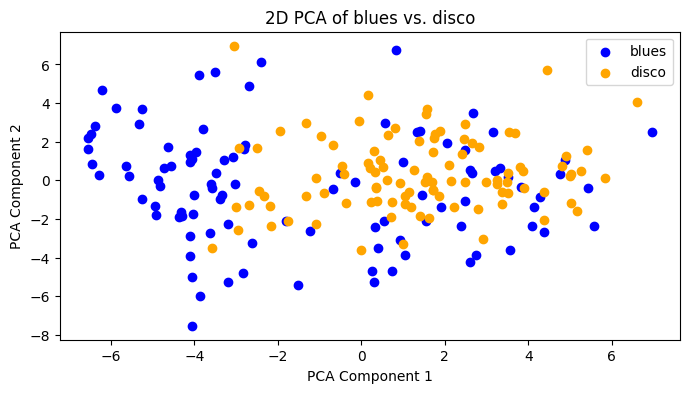

In [62]:
if __name__ == "__main__":
    all_photos, all_attrs = prepare_data(DATASET_PATH)
    encoder = load_model(ENCODER_PATH)
    class1_index = classes.index(class1)
    class2_index = classes.index(class2)
    class1_idx = np.where(all_attrs == class1_index)
    class2_idx = np.where(all_attrs == class2_index)

    data1 = all_photos[class1_idx]
    data2 = all_photos[class2_idx]

    # Visualize latent space
    latent_space_2d(encoder, data1, class1, data2, class2)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


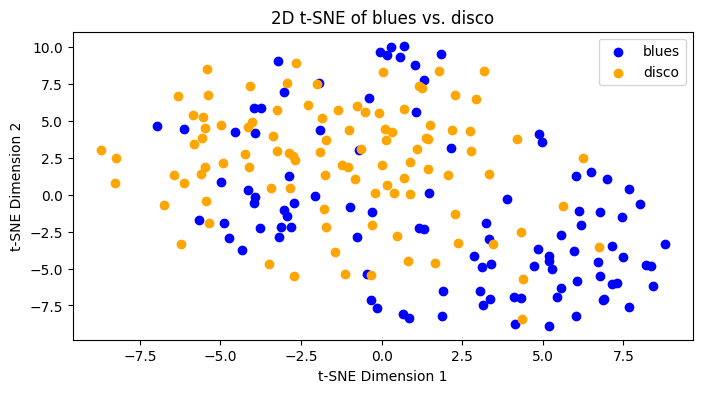

In [63]:
# ✅ t-SNE version of latent space visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def latent_space_tsne(encoder, data1, label1, data2, label2, perplexity=30, n_iter=1000):
    """Visualize latent space using t-SNE"""
    # Encode images
    data1_encoding = encode_images(encoder, data1)
    data2_encoding = encode_images(encoder, data2)

    # Flatten
    data1_flat = data1_encoding.reshape(data1_encoding.shape[0], -1)
    data2_flat = data2_encoding.reshape(data2_encoding.shape[0], -1)

    # Combine data
    combined_data = np.vstack((data1_flat, data2_flat))
    combined_labels = np.array([label1] * len(data1_flat) + [label2] * len(data2_flat))

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, init='pca', random_state=42)
    transformed_data = tsne.fit_transform(combined_data)

    # Split back for visualization
    transformed_data1 = transformed_data[:len(data1)]
    transformed_data2 = transformed_data[len(data1):]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.scatter(transformed_data1[:, 0], transformed_data1[:, 1], color='blue', label=label1)
    plt.scatter(transformed_data2[:, 0], transformed_data2[:, 1], color='orange', label=label2)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title(f"2D t-SNE of {label1} vs. {label2}")
    plt.legend()
    plt.grid(False)
    plt.show()

# ✅ Usage example (right below PCA):
latent_space_tsne(encoder, data1, class1, data2, class2)

TSNE Grid search

In [71]:
def run_tsne_grid_search_multiclass(encoder, all_photos, all_attrs, class_names,
                                     perplexity_list=[5, 30, 50],
                                     n_iter_list=[500, 1000, 2000],
                                     save_fig=False):
    """
    Run t-SNE grid search on all classes.
    """
    # 准备所有类别的图像与标签
    data_list = []
    label_list = []
    for idx, name in enumerate(class_names):
        indices = np.where(all_attrs == idx)[0]
        imgs = all_photos[indices]
        data_list.append(imgs)
        label_list.extend([idx] * len(imgs))

    combined_data = np.vstack(data_list)
    combined_labels = np.array(label_list)

    # 编码
    encoded = encode_images(encoder, combined_data)
    flattened = encoded.reshape(encoded.shape[0], -1)

    total = len(perplexity_list) * len(n_iter_list)
    count = 1

    for perplexity in perplexity_list:
        for n_iter in n_iter_list:
            tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, init='pca', random_state=42)
            transformed_data = tsne.fit_transform(flattened)

            # 画图
            plt.figure(figsize=(10, 6))
            scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1],
                                  c=combined_labels, cmap='tab10', alpha=0.7)
            handles, _ = scatter.legend_elements()
            plt.legend(handles, class_names, title="Genres", loc="best")
            plt.xlabel("t-SNE Dimension 1")
            plt.ylabel("t-SNE Dimension 2")
            plt.title(f"t-SNE Grid Search | perplexity={perplexity}, n_iter={n_iter}")
            plt.grid(False)

            if save_fig:
                fname = f"tsne_allgenres_p{perplexity}_n{n_iter}.png"
                plt.savefig(fname, dpi=150, bbox_inches='tight')

            plt.show()
            print(f"[{count}/{total}] ✅ done: perplexity={perplexity}, n_iter={n_iter}")
            count += 1


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


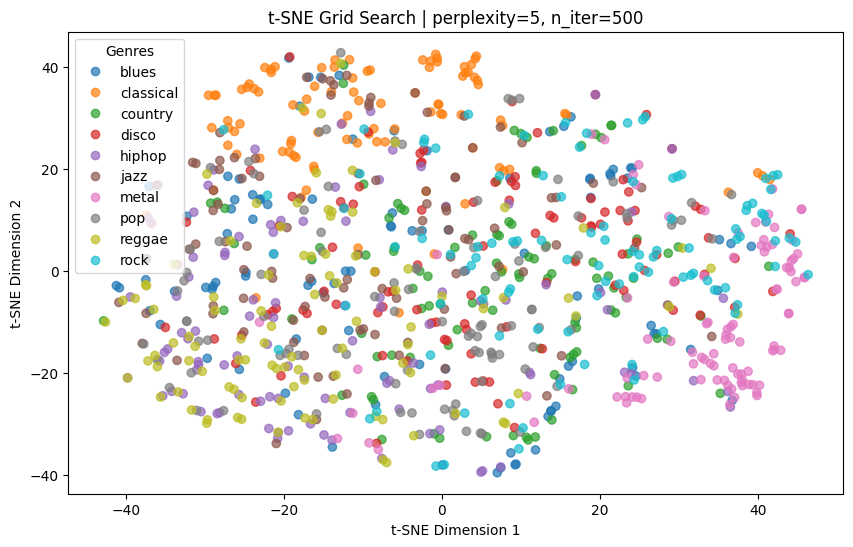

[1/9] ✅ done: perplexity=5, n_iter=500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


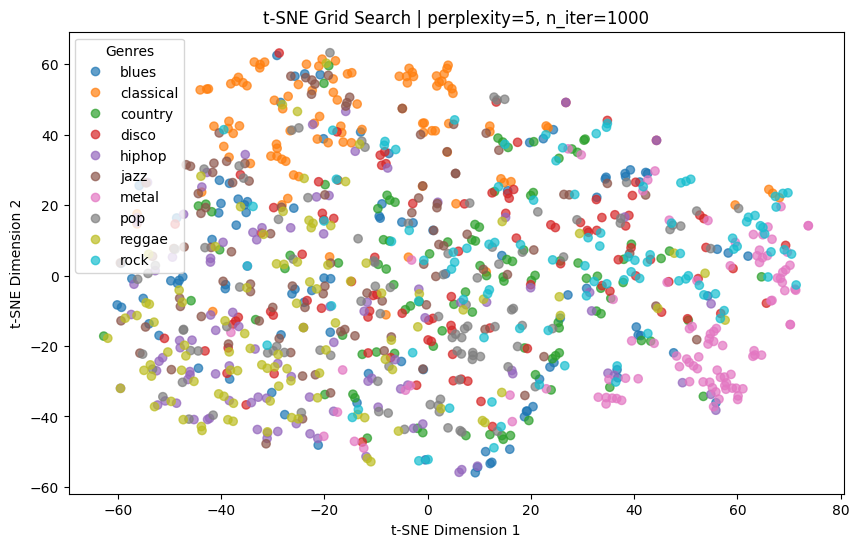

[2/9] ✅ done: perplexity=5, n_iter=1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


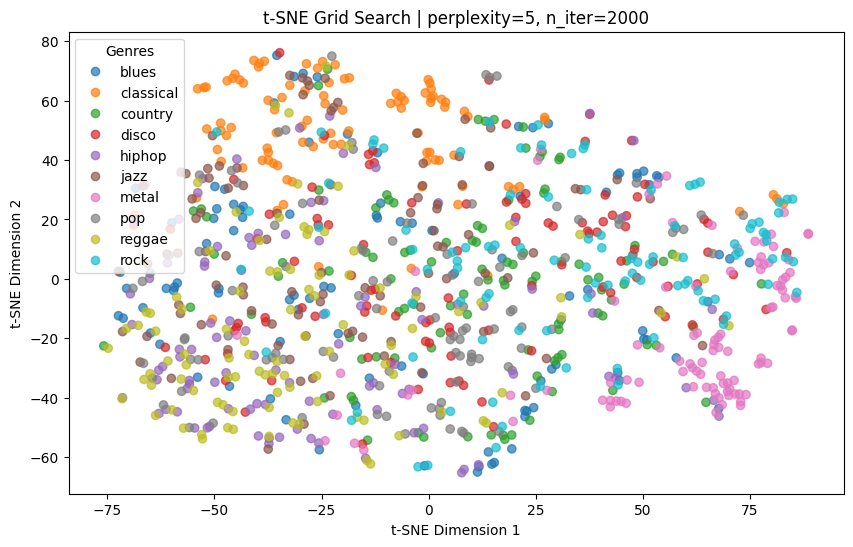

[3/9] ✅ done: perplexity=5, n_iter=2000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


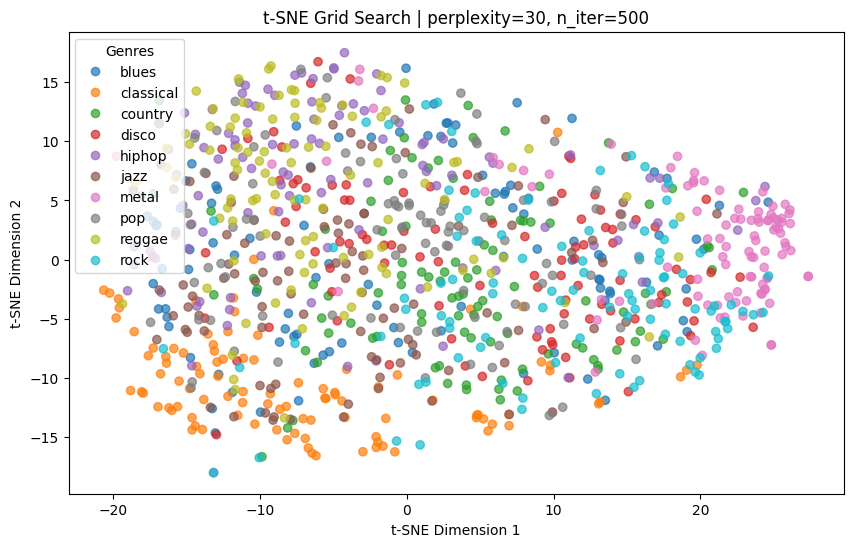

[4/9] ✅ done: perplexity=30, n_iter=500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


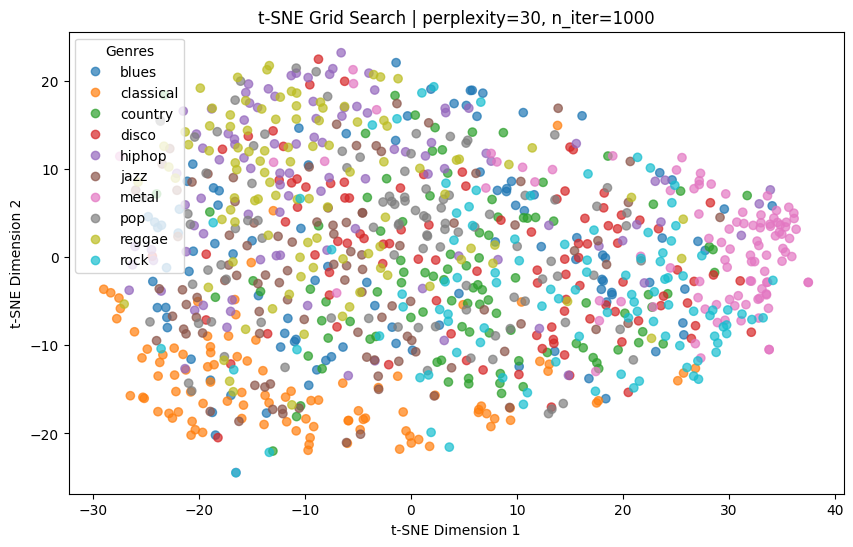

[5/9] ✅ done: perplexity=30, n_iter=1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


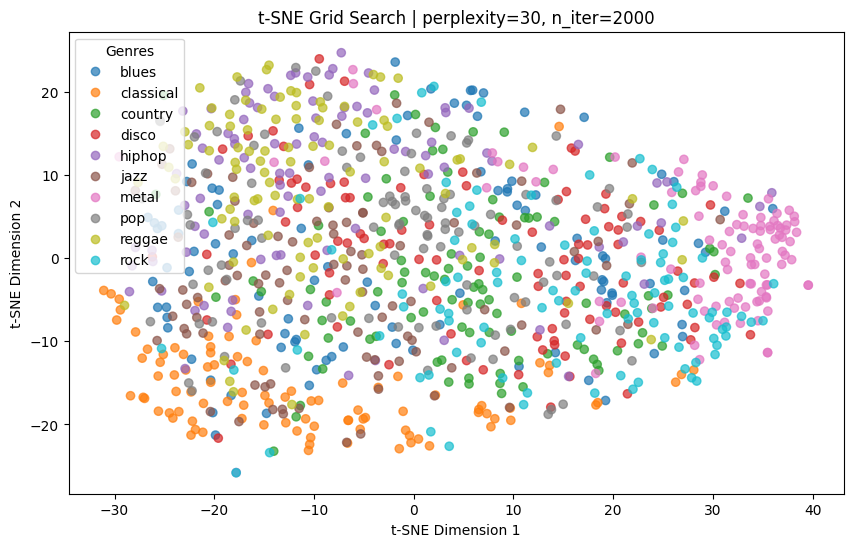

[6/9] ✅ done: perplexity=30, n_iter=2000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


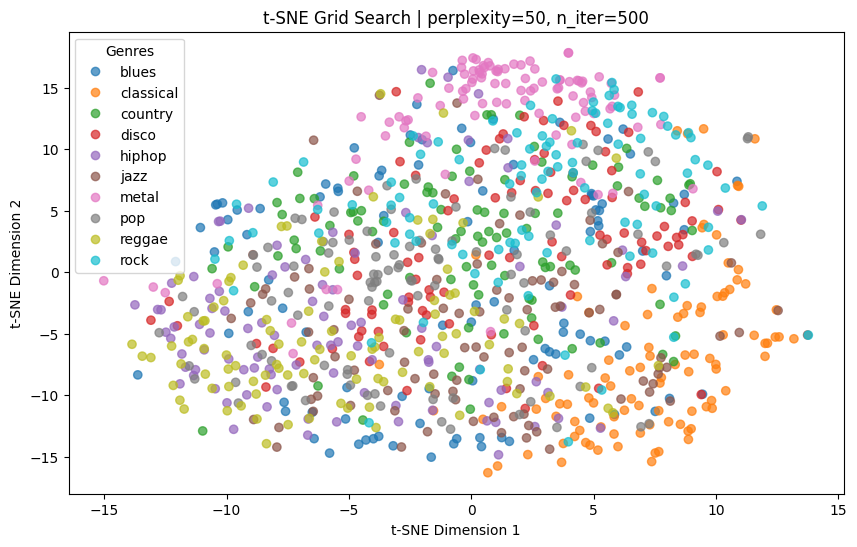

[7/9] ✅ done: perplexity=50, n_iter=500


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


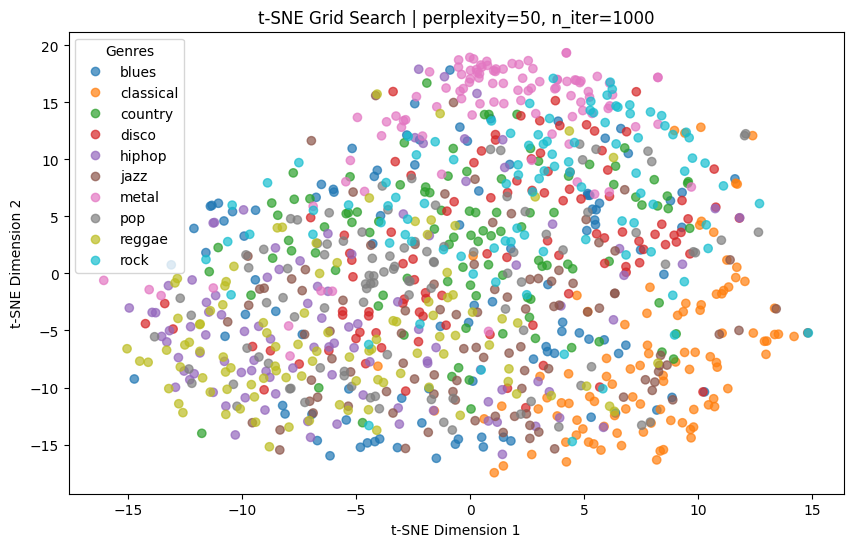

[8/9] ✅ done: perplexity=50, n_iter=1000


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


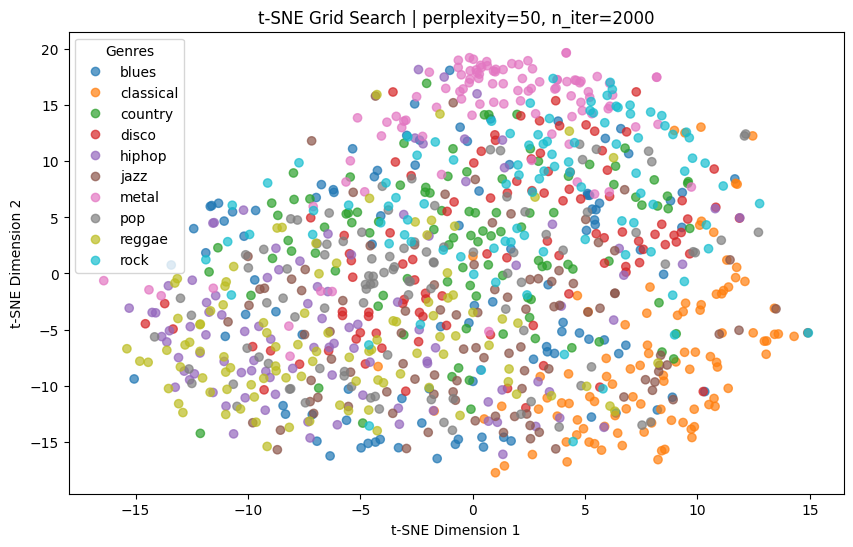

[9/9] ✅ done: perplexity=50, n_iter=2000


In [72]:

run_tsne_grid_search_multiclass(encoder, all_photos, all_attrs, classes)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


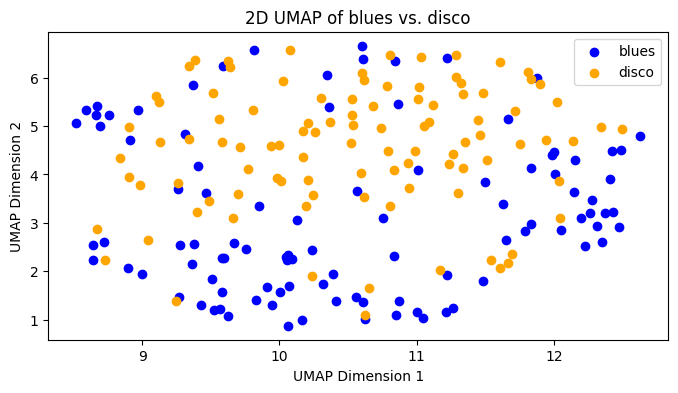

In [67]:
latent_space_umap(encoder, data1, class1, data2, class2)


UMAP Grid Search

In [69]:
def run_umap_grid_search(encoder, all_photos, all_attrs, class_names,
                         n_neighbors_list=[5, 15, 30], min_dist_list=[0.0, 0.1, 0.5],
                         metrics=['euclidean', 'cosine'], save_fig=False):
    """
    Grid search for UMAP visualization over multiple parameter combinations.
    """
    # 准备数据
    data_list = []
    label_list = []
    for idx, name in enumerate(class_names):
        indices = np.where(all_attrs == idx)[0]
        imgs = all_photos[indices]
        data_list.append(imgs)
        label_list.extend([idx] * len(imgs))

    all_data = np.vstack(data_list)
    encoded = encode_images(encoder, all_data)
    flattened = encoded.reshape(encoded.shape[0], -1)

    total = len(n_neighbors_list) * len(min_dist_list) * len(metrics)
    count = 1

    for nn in n_neighbors_list:
        for md in min_dist_list:
            for metric in metrics:
                reducer = umap.UMAP(n_neighbors=nn, min_dist=md, metric=metric, random_state=42)
                embedding = reducer.fit_transform(flattened)

                plt.figure(figsize=(10, 6))
                scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=label_list, cmap='tab10', alpha=0.7)
                handles, _ = scatter.legend_elements()
                plt.legend(handles, class_names, title="Genres", loc="best")
                plt.xlabel("UMAP Dimension 1")
                plt.ylabel("UMAP Dimension 2")
                plt.title(f"UMAP: n_neighbors={nn}, min_dist={md}, metric={metric}")
                plt.grid(False)

                if save_fig:
                    fname = f"umap_nn{nn}_md{int(md*100)}_metric{metric}.png"
                    plt.savefig(fname, dpi=150, bbox_inches='tight')

                plt.show()
                print(f"[{count}/{total}] ✅ done: n_neighbors={nn}, min_dist={md}, metric={metric}")
                count += 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


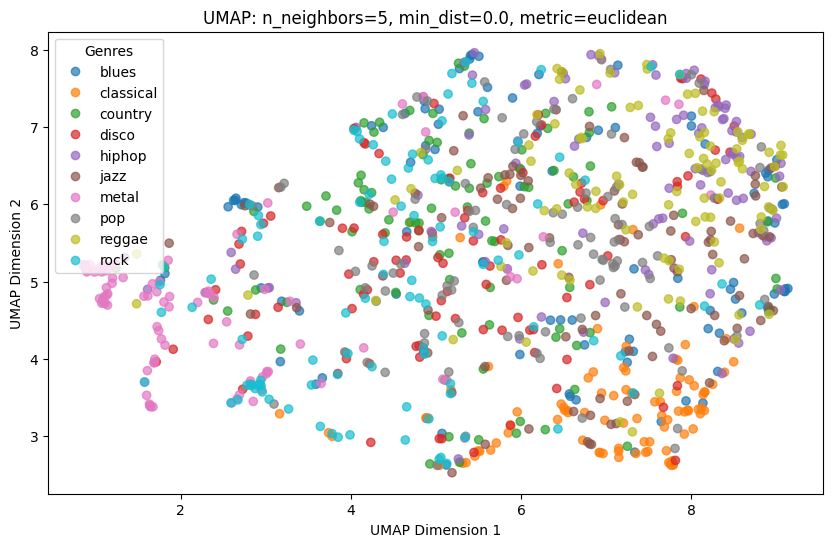

[1/18] ✅ done: n_neighbors=5, min_dist=0.0, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


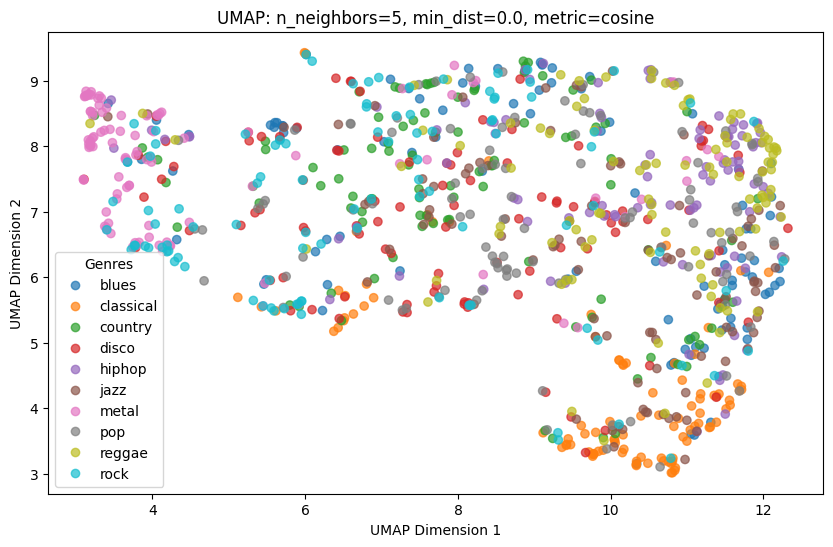

[2/18] ✅ done: n_neighbors=5, min_dist=0.0, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


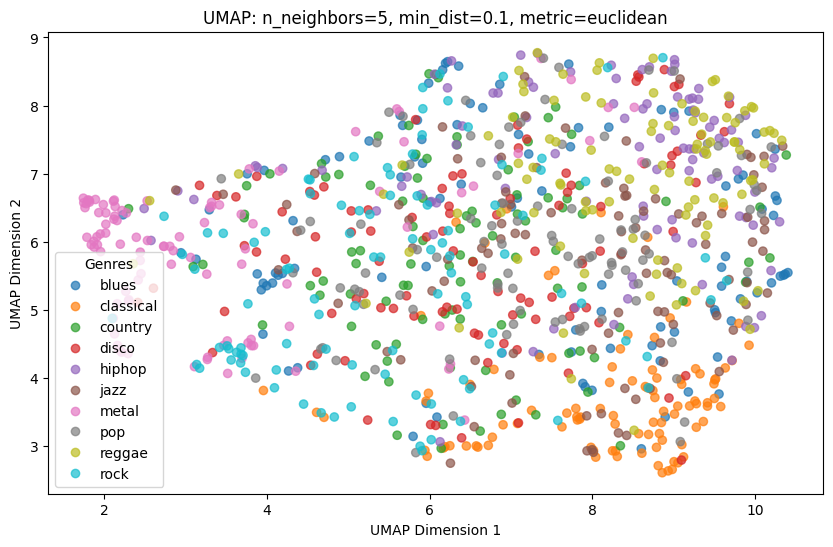

[3/18] ✅ done: n_neighbors=5, min_dist=0.1, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


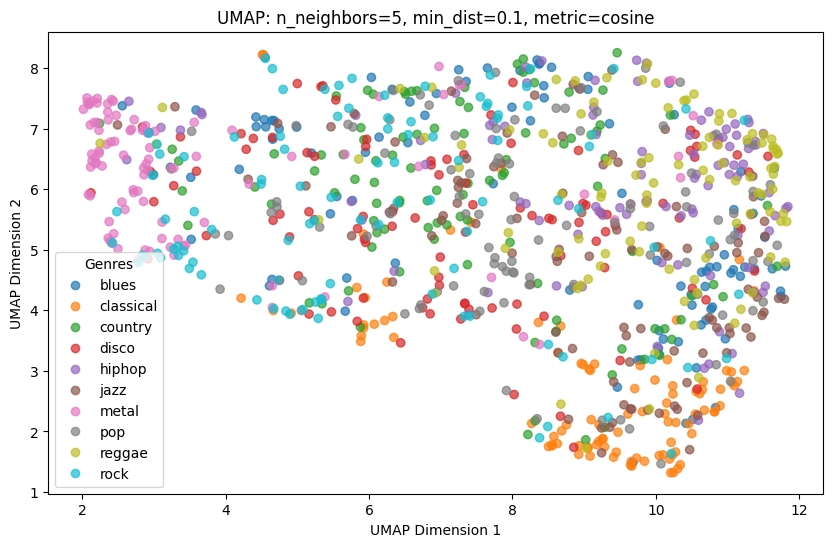

[4/18] ✅ done: n_neighbors=5, min_dist=0.1, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


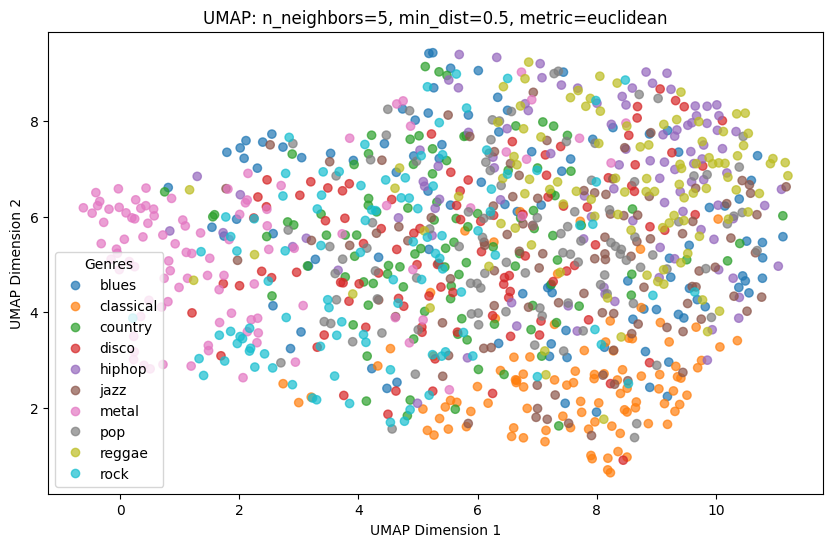

[5/18] ✅ done: n_neighbors=5, min_dist=0.5, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


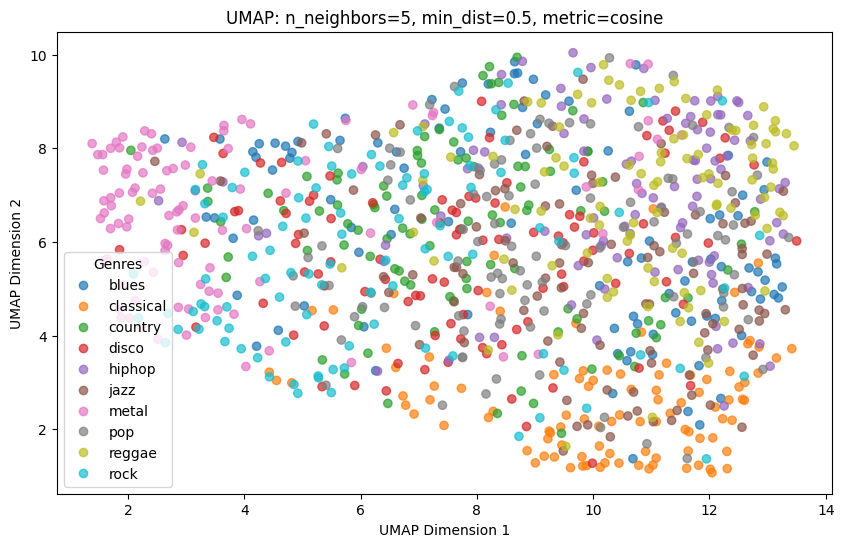

[6/18] ✅ done: n_neighbors=5, min_dist=0.5, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


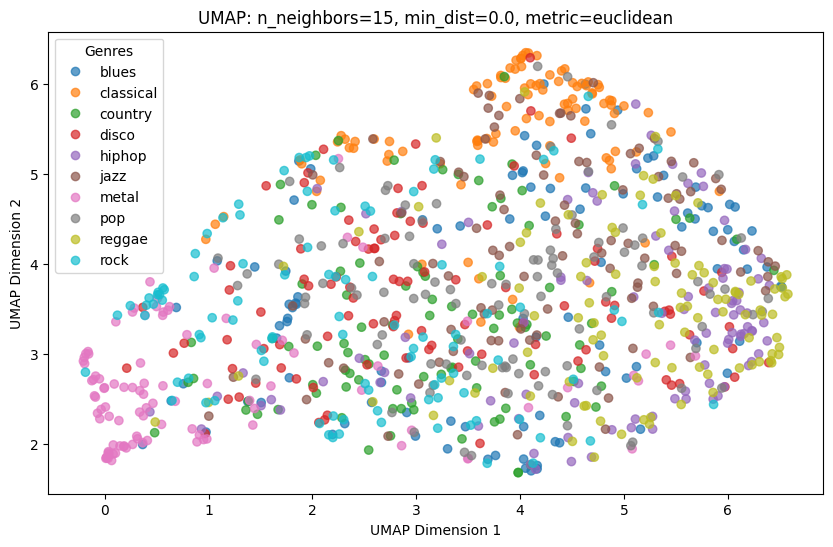

[7/18] ✅ done: n_neighbors=15, min_dist=0.0, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


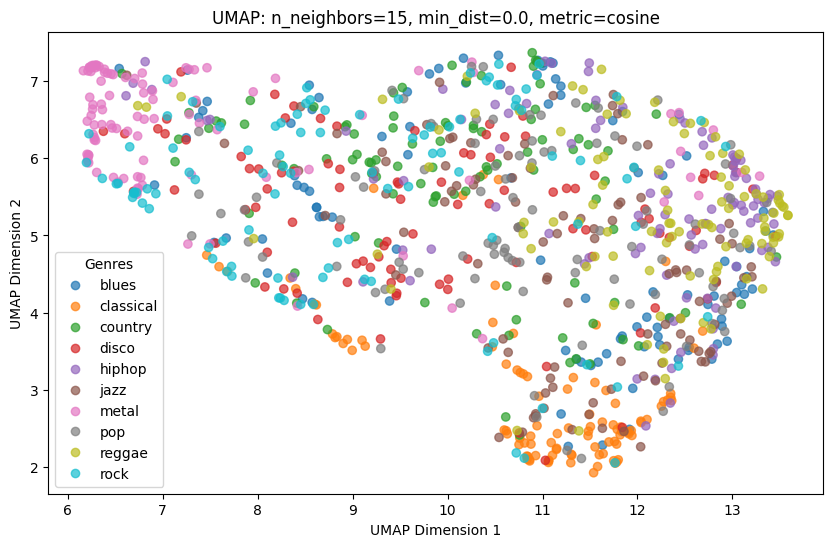

[8/18] ✅ done: n_neighbors=15, min_dist=0.0, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


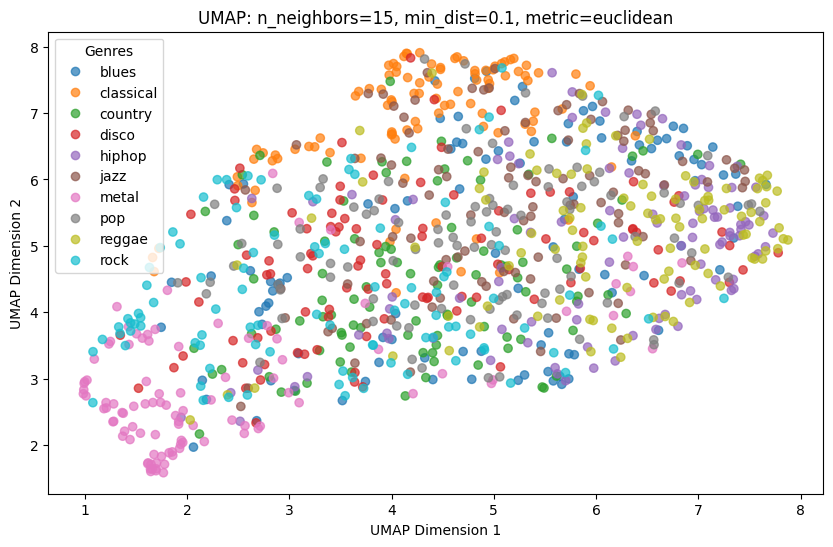

[9/18] ✅ done: n_neighbors=15, min_dist=0.1, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


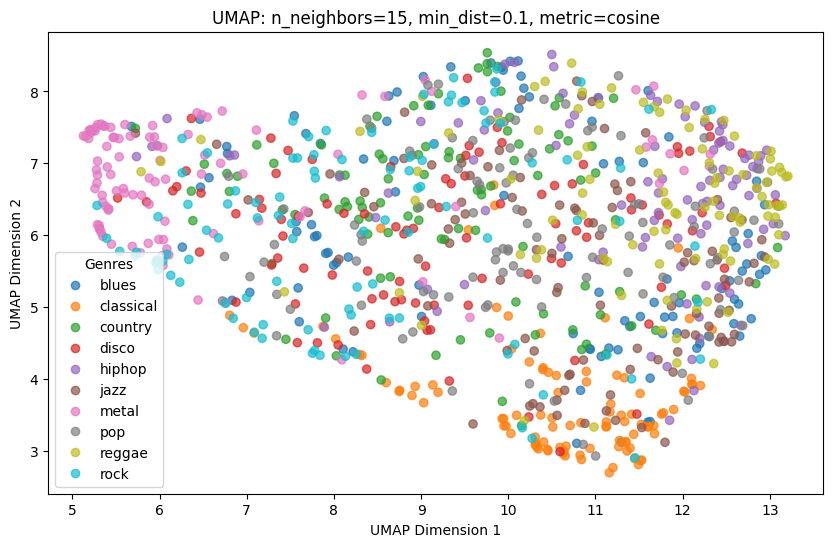

[10/18] ✅ done: n_neighbors=15, min_dist=0.1, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


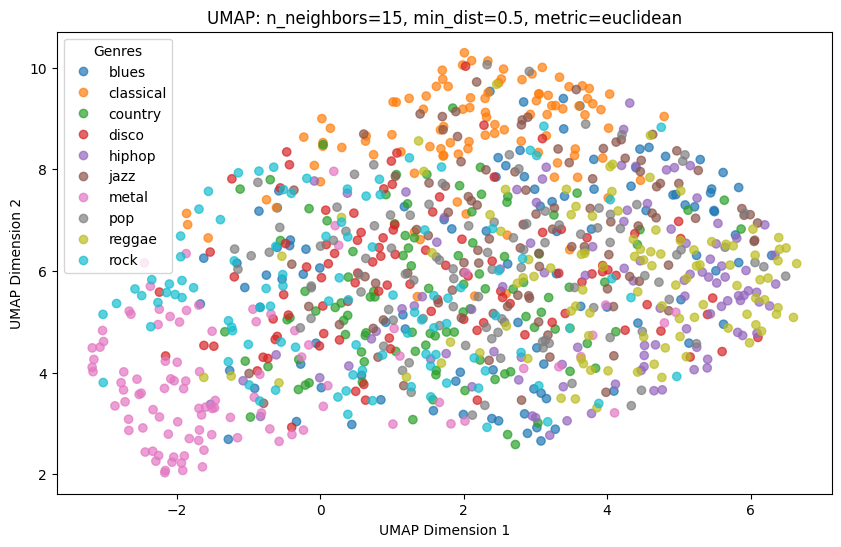

[11/18] ✅ done: n_neighbors=15, min_dist=0.5, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


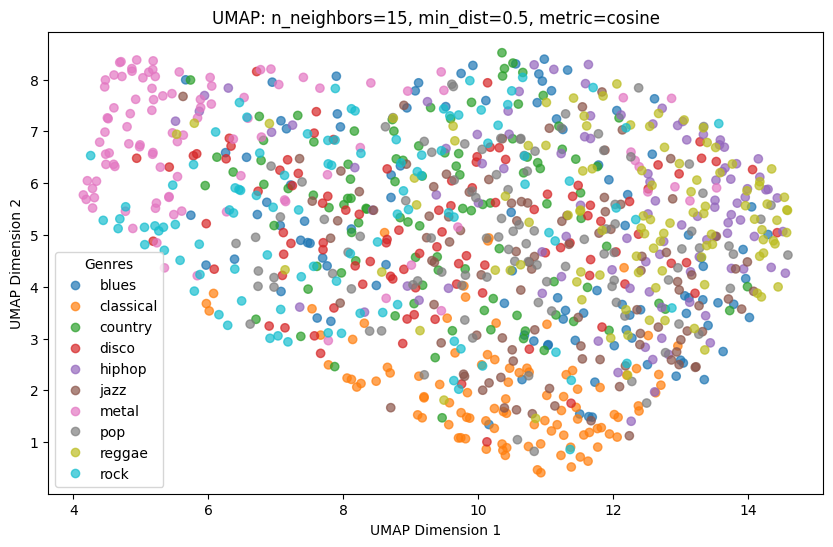

[12/18] ✅ done: n_neighbors=15, min_dist=0.5, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


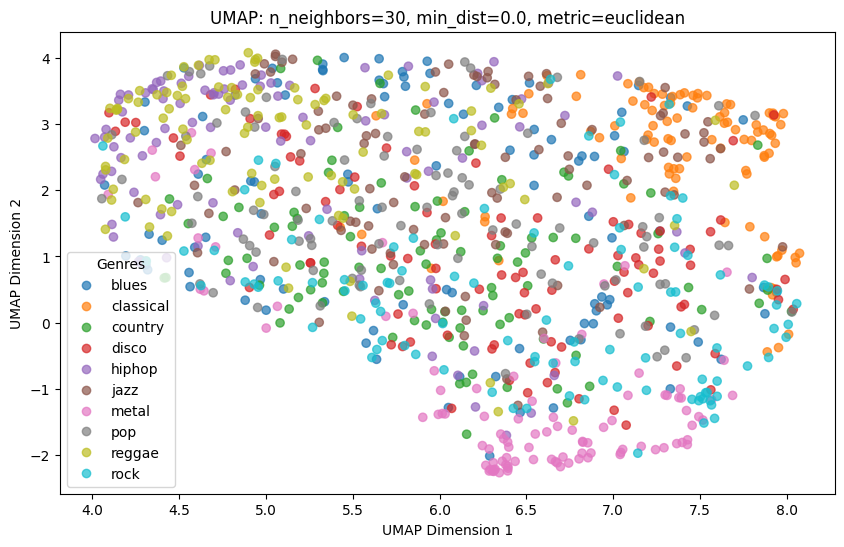

[13/18] ✅ done: n_neighbors=30, min_dist=0.0, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


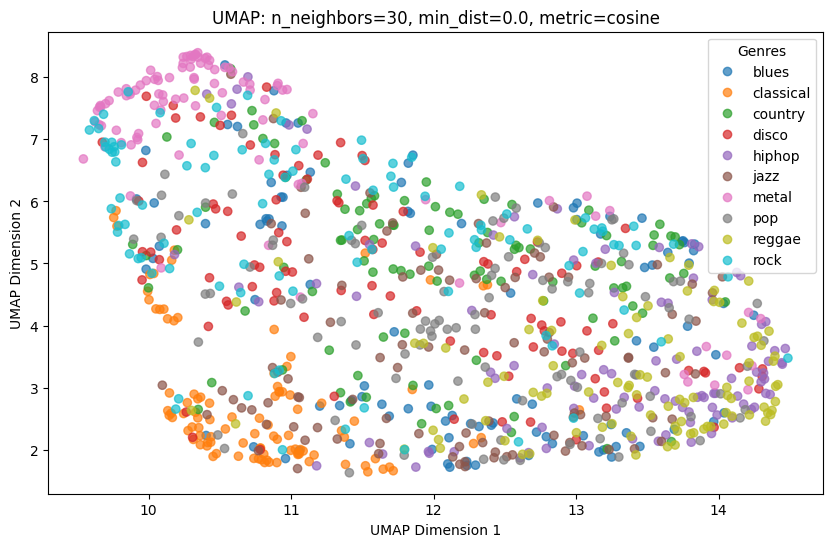

[14/18] ✅ done: n_neighbors=30, min_dist=0.0, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


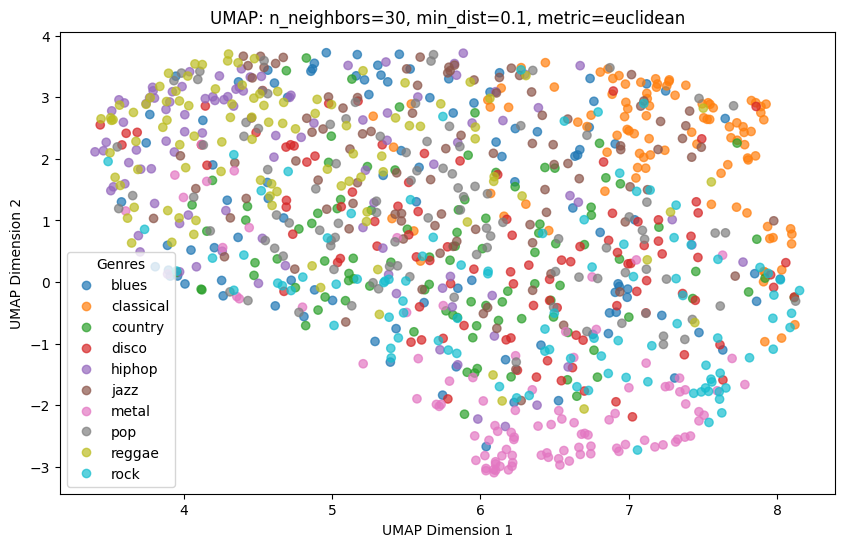

[15/18] ✅ done: n_neighbors=30, min_dist=0.1, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


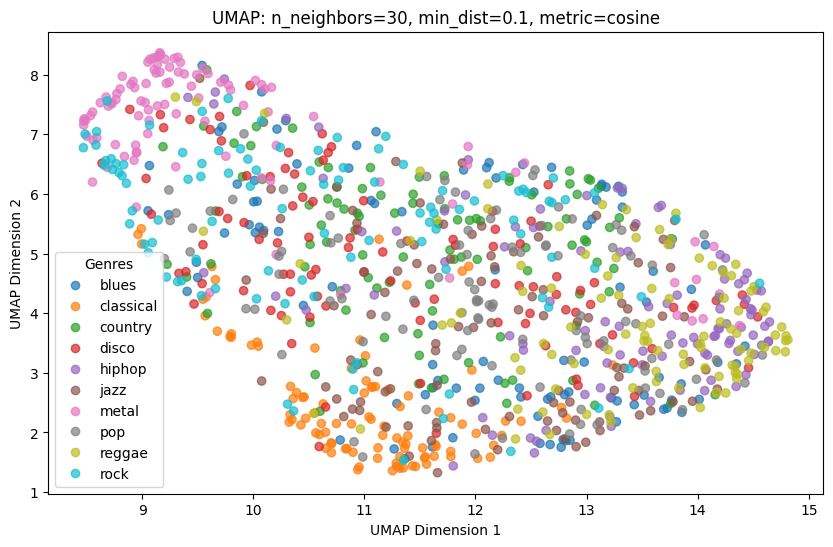

[16/18] ✅ done: n_neighbors=30, min_dist=0.1, metric=cosine


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


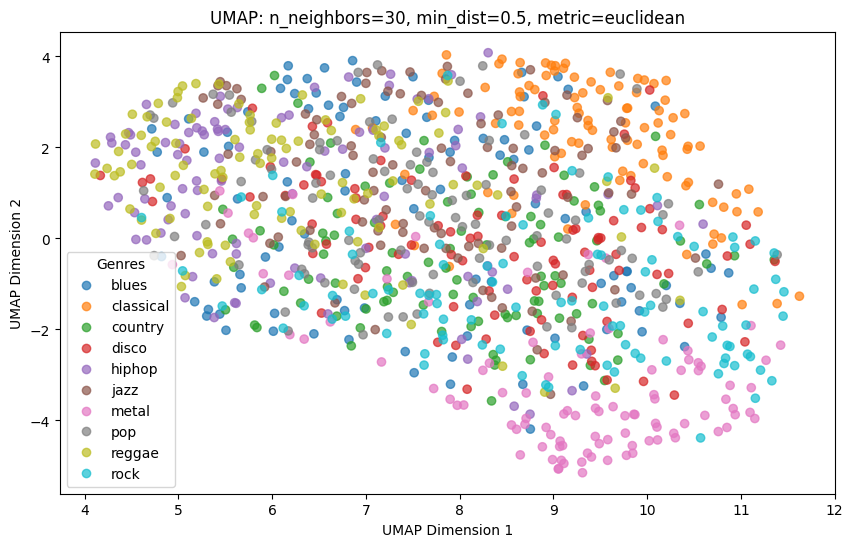

[17/18] ✅ done: n_neighbors=30, min_dist=0.5, metric=euclidean


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


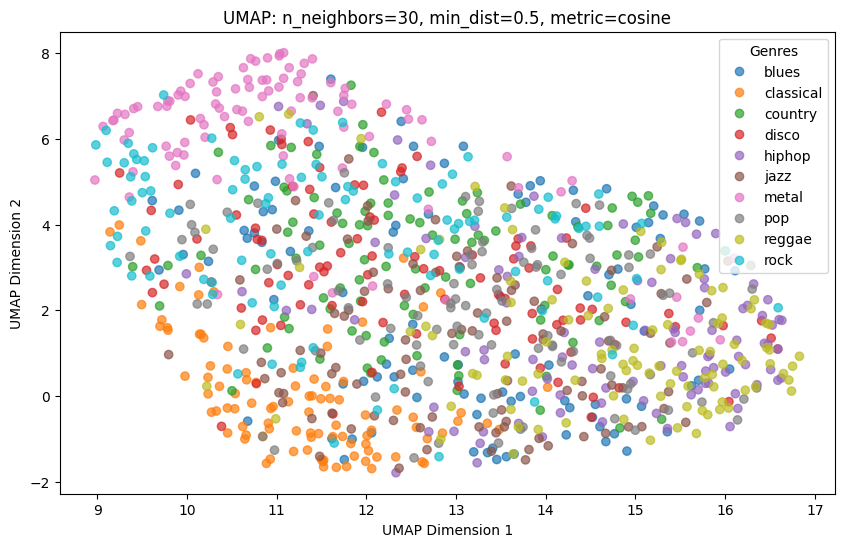

[18/18] ✅ done: n_neighbors=30, min_dist=0.5, metric=cosine


In [70]:
run_umap_grid_search(encoder, all_photos, all_attrs, classes)
